In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..',
    )

In [2]:
snakemake.input['quantseq']

'/home/cs/Projects/lapa/data/results/lapa/WTC11/quantseq_end'

In [3]:
import matplotlib.pyplot as plt
import pyranges as pr
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc

In [4]:
core_cols = ['Chromosome', 'Start', 'End', 'Strand']

In [5]:
result_quantseq = LapaResult(snakemake.input['quantseq'], tpm_cutoff=1)
result_cdna_ont = LapaResult(snakemake.input['cdna_ont'], tpm_cutoff=0)
result_cdna_pacbio = LapaResult(snakemake.input['cdna_pacbio'], tpm_cutoff=0)
result_drna_ont = LapaResult(snakemake.input['drna_ont'], tpm_cutoff=0)

In [6]:
replicated = (result_quantseq.counts() > 0).all(axis=1)

df_quantseq = LapaResult(snakemake.input['quantseq'], tpm_cutoff=0) \
    .read_cluster(filter_internal_priming=False).drop_duplicates(core_cols)
df_quantseq = df_quantseq.loc[replicated[replicated].index]

In [27]:
gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [28]:
gr_cdna_ont = pr.PyRanges(result_cdna_ont.read_apa('all').drop_duplicates(core_cols), int64=True)

In [29]:
gr_cdna_pacbio = pr.PyRanges(result_cdna_pacbio.read_apa('all').drop_duplicates(core_cols), int64=True)

In [30]:
gr_drna_ont = pr.PyRanges(result_drna_ont.read_apa('all').drop_duplicates(core_cols), int64=True)

In [31]:
def join_outer(gr1, gr2, suffix):
    return gr1.join(gr2, strandedness='same', how='outer', slack=50, suffix=suffix)
    
    #df.loc[df['Start'] == -1, 'Start'] = df.loc[df['Start'] == -1, f'Start{suffix}']
    #df.loc[df['End'] == -1, 'End'] = df.loc[df['End'] == -1, f'End{suffix}']
    #df.loc[df['Strand'] == -1, 'Strand'] = df.loc[df['Strand'] == -1, f'Strand{suffix}']
       
    #return pr.PyRanges(df)

In [32]:
gr_drna_ont

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,gene_id,count,gene_count,usage,fracA,signal,canonical_site
0,ERCC-00002,1043,1045,1045,2206.14,+,exon,ERCC-00002A,118,118,1.0,0,None@None,-1
1,ERCC-00003,1006,1007,1007,74.78,+,exon,ERCC-00003A,4,4,1.0,0,None@None,-1
2,ERCC-00004,505,507,507,841.33,+,exon,ERCC-00004A,45,45,1.0,0,521@GATAAA,-1
3,ERCC-00042,1006,1007,1007,74.78,+,exon,ERCC-00042A,4,4,1.0,0,None@None,-1
4,ERCC-00046,505,506,506,523.49,+,exon,ERCC-00046A,28,28,1.0,0,505@ATTAAA,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,chrX,154348527,154348532,154348529,878.72,-,UTR,ENSG00000196924.19,47,47,1.0,0,154348565@AATAAA,-1
2547,chrX,72272601,72272611,72272602,1233.94,-,UTR,ENSG00000198034.11,66,66,1.0,0,72272631@ATTAAA,-1
2548,chrY,12920477,12920478,12920478,74.78,+,UTR,ENSG00000067048.17,4,4,1.0,0,12920518@AATAAA,-1
2549,chrY,2866946,2866951,2866948,710.45,+,UTR,ENSG00000129824.16,38,38,1.0,2,2866987@AATAAA,-1


In [33]:
gr_cdna_pacbio

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,gene_id,count,gene_count,usage,fracA,signal,canonical_site
0,ERCC-00002,155,156,156,2.53,+,exon,ERCC-00002A,13,14608,0.000890,2,205@AAGAAA,-1
1,ERCC-00002,214,215,215,1.75,+,exon,ERCC-00002A,9,14608,0.000616,5,277@AATATA,-1
2,ERCC-00002,682,683,683,0.78,+,exon,ERCC-00002A,4,14608,0.000274,2,None@None,-1
3,ERCC-00002,1036,1045,1043,2836.86,+,exon,ERCC-00002A,14582,14608,0.998220,0,None@None,-1
4,ERCC-00003,998,1007,1006,173.34,+,exon,ERCC-00003A,891,891,1.000000,0,None@None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,chrY,18932697,18932702,18932698,1.36,-,exon,ENSG00000176728.10,7,40,0.175000,3,18932731@AATAAA,-1
32996,chrY,19065488,19065489,19065489,1.36,-,intron,ENSG00000176728.10,7,40,0.175000,8,19065546@AAGAAA,-1
32997,chrY,13234574,13234585,13234576,15.56,-,exon,ENSG00000183878.16,80,112,0.714286,2,13234602@AATAAA,-1
32998,chrY,13248383,13248384,13248384,0.58,-,UTR,ENSG00000183878.16,3,112,0.026786,0,13248423@AATAAT,-1


In [34]:
df_cdna_ont = join_outer(gr_quantseq, gr_cdna_ont, '_cdna_ont').df
df_cdna_pacbio = join_outer(gr_quantseq, gr_cdna_pacbio, '_cdna_pacbio').df
df_drna_ont = join_outer(gr_quantseq, gr_drna_ont, '_drna_ont').df
#gr = join_outer(gr, gr_long, '_long')
#gr = join_outer(gr, gr_short, '_short')

In [35]:
df_cdna_ont

,Chromosome,Start,End,polyA_site,tpm,Strand,Feature,count,fracA,signal,...,tpm_cdna_ont,Strand_cdna_ont,Feature_cdna_ont,gene_id,count_cdna_ont,gene_count,usage,fracA_cdna_ont,signal_cdna_ont,canonical_site_cdna_ont
0,ERCC-00074,501,506,506,3.203623,+,exon,250,0,None@None,...,444.47,+,exon,ERCC-00074A,3670,3886,0.944416,4,None@None,-1
1,ERCC-00074,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,...,0.61,+,exon,ERCC-00074A,5,3886,0.001287,4,None@None,-1
2,ERCC-00074,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,...,0.48,+,exon,ERCC-00074A,4,3886,0.001029,3,174@ATTAAA,-1
3,ERCC-00074,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,...,2.79,+,exon,ERCC-00074A,23,3886,0.005919,4,174@ATTAAA,-1
4,ERCC-00074,-1,-1,-1,-1.000000,+,-1,-1,-1,-1,...,0.97,+,exon,ERCC-00074A,8,3886,0.002059,3,212@CATAAA,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39119,chrY,-1,-1,-1,-1.000000,-,-1,-1,-1,-1,...,0.36,-,exon,ENSG00000176728.10,3,119,0.025210,1,18932041@AATAAA,-1
39120,chrY,-1,-1,-1,-1.000000,-,-1,-1,-1,-1,...,0.36,-,intron,ENSG00000176728.10,3,119,0.025210,2,18992136@AATAAA,-1
39121,chrY,-1,-1,-1,-1.000000,-,-1,-1,-1,-1,...,1.57,-,exon,ENSG00000183878.16,13,13,1.000000,1,13234610@AATAAA,-1
39122,chrY,-1,-1,-1,-1.000000,-,-1,-1,-1,-1,...,0.48,-,exon,ENSG00000215580.11,4,4,1.000000,3,19555420@AATAAA,-1


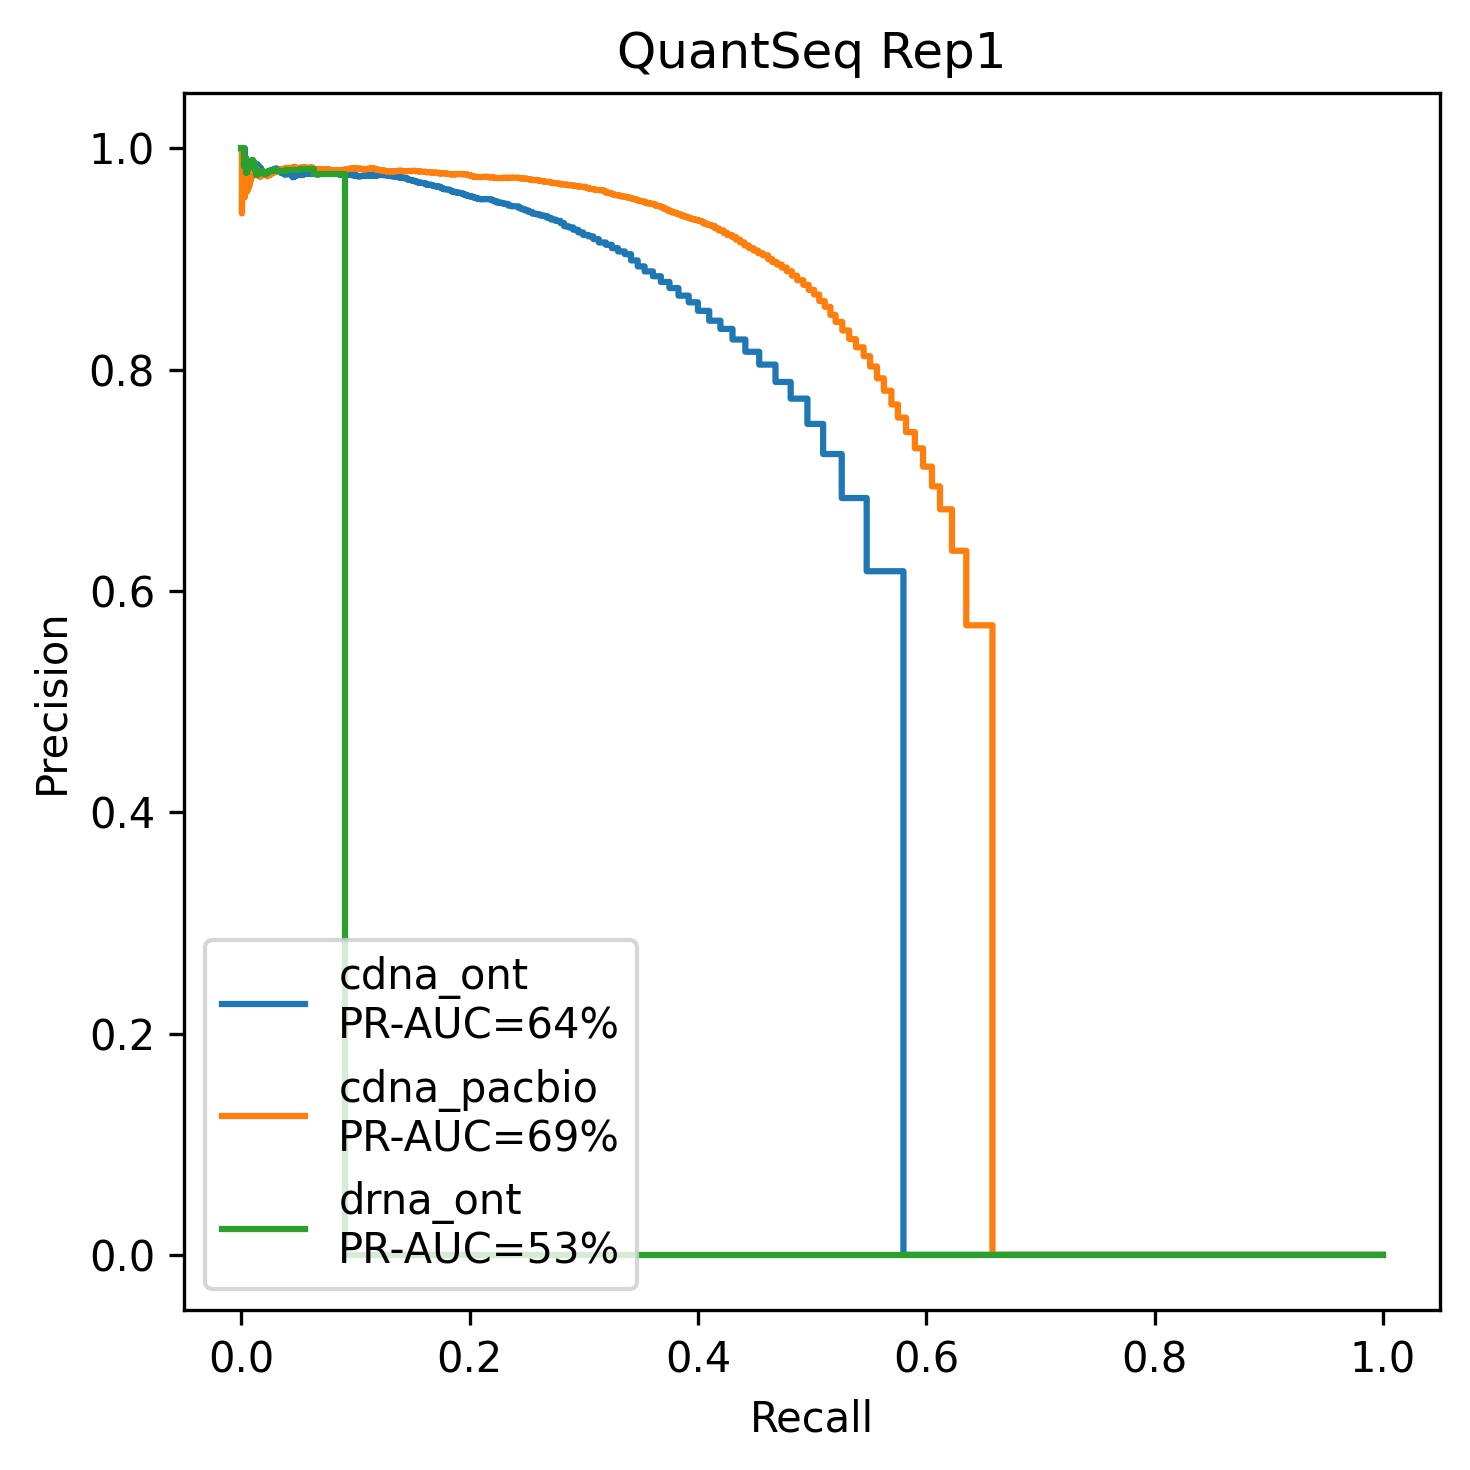

In [37]:
plt.figure(figsize=(5, 5), dpi=300)
plt.title('QuantSeq Rep1')


for label, df in [('cdna_ont', df_cdna_ont), ('cdna_pacbio', df_cdna_pacbio), ('drna_ont', df_drna_ont)]:
    
    ground_truth = list((~(df['tpm'] == -1)).astype(int))
    score = df[f'tpm_{label}']
    
       
    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0
    label = f'{label}\nPR-AUC={int(auc(recall, prec) * 100)}%'
    plt.step(recall, prec, where='post', label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
#plt.savefig(snakemake.output['rep1'], bbox_inches = "tight")